In [46]:
# Option pricing using the Monte Carlo method
# Here we consider such an option with Apple as the underlying asset

import yfinance as yf
import numpy as np
import pandas as pd

# Let us start with the Monte Carlo approach:
# The pricing parameters are: the spot price, the strike, the implied volatility,
# the risk-free interest rate, dividends, and maturity

# Let us start by extracting the parameters for which the data is up to date

In [54]:
# Firstly, the spot:

ticker = yf.Ticker("AAPL")
S0 = ticker.history(period="1d")["Close"].iloc[-1]
print("Spot Apple :", S0)


Spot Apple : 259.4800109863281


In [48]:
# Then, the implied volatility:

expiry = ticker.options[0]  # the closest maturity
options = ticker.option_chain(expiry)
calls = options.calls

# Example : take the implied volatility of the closest ATM call
atm_call = calls.iloc[(calls['strike'] - S0).abs().argsort()[:1]]
sigma = atm_call['impliedVolatility'].values[0]

print(sigma)

0.213875048828125


In [49]:
# Finally, the risk-free interest rate:
# For US treasuries: ^IRX -> 3M  ;  ^FVX -> 5Y  ;  ^TNX -> 10Y  . ^TYX -> 30Y

rf = yf.Ticker("^IRX").history(period="1d")["Close"].iloc[-1] / 100
print("Risk-free rate :", rf)

Risk-free rate : 0.03572000026702881


In [50]:
# Let us write the pricing function for a European call/put option

def MC_call(S0, K, T, r,q, sigma, n_sim, option_type="call" ):
    # Generation of normal variables
    Z = np.random.standard_normal(n_sim)
    
    # Simulation of the final price
    ST = S0 * np.exp((r-q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    
    if option_type.lower() == "call":
        payoff = np.maximum(ST - K, 0)
    elif option_type.lower() == "put":
        payoff = np.maximum(K - ST, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
        
    price = np.exp(-r * T) * np.mean(payoff)
    return price


In [51]:
# Let us test our function:

call_price=MC_call(S0, 250, 0.5,rf,0, sigma, 100000, "CALL")
put_price=MC_call(S0, 250, 0.5,rf,0, sigma, 100000, "put")

print(f"With Monte Carlo, Call price AAPL : {call_price:.2f} $")
print(f"With Monte Carlo, Put price AAPL : {put_price:.2f} $")

With Monte Carlo, Call price AAPL : 23.26 $
With Monte Carlo, Put price AAPL : 9.36 $


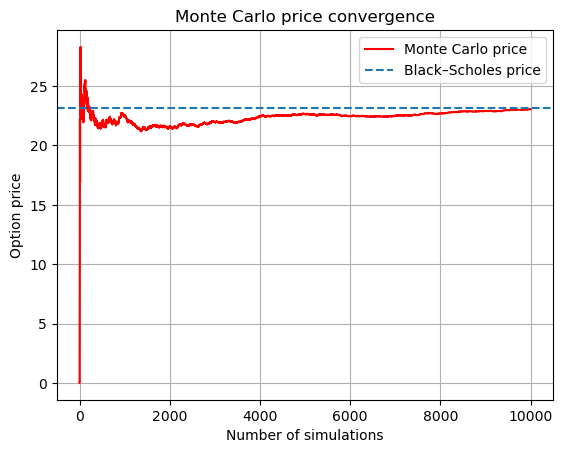

As the number of simulations increases, the Monte Carlo estimator converges to the Black–Scholes analytical price, illustrating the law of large numbers.


In [65]:
from scipy.stats import norm

# Our data:
n_simulations = 10000
K=250 
T=0.5
q=0
payoffs = []
prices_mc = []

# Let us start by writing the Black-Scholes formula for an european call:
def BS_price(S0, K, T, rf, q, sigma, option_type="call"):

    d1 = (np.log(S0 / K) + (rf-q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type.lower() == "call":
        price = S0 * np.exp(-q * T) *norm.cdf(d1) - K * np.exp(-rf * T) * norm.cdf(d2)
    elif option_type.lower() == "put":
        price = K * np.exp(-rf * T) * norm.cdf(-d2) - S* np.exp(-q * T) * norm.cdf(-d1)
    else:
        raise ValueError("option_type doit être 'call' ou 'put'")

    return price

# Then, write our simulation
for i in range(1, n_simulations + 1):
    Z = np.random.normal()
    S_T = S0 * np.exp((rf- q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoff = max(S_T - K, 0)   # call
    payoffs.append(payoff)
    prices_mc.append(np.exp(-rf * T) * np.mean(payoffs))

bs_price = BS_price(S0, K, T, rf, 0, sigma, "call")

# Graph:
plt.plot(prices_mc, color='red',label="Monte Carlo price")
plt.axhline(bs_price, linestyle='--', label="Black–Scholes price")
plt.xlabel("Number of simulations")
plt.ylabel("Option price")
plt.title("Monte Carlo price convergence")
plt.legend()
plt.grid(True)
plt.show()

print("As the number of simulations increases, the Monte Carlo estimator converges to the Black–Scholes analytical price, illustrating the law of large numbers.")
